# Numpy – klasteryzacja

Zaimplementuj z wykorzystaniem biblioteki numpy algorytm K-means clustering, który służy do automatycznego wykrywania klastrów (skupisk) punktów w przestrzeni, np. dwuwymiarowej (lub innej). Objaśnienie zasady działania znajdziesz poniżej.

## Reguły
### Wyjaśnienie działania klasteryzacji na przykładzie algorytmu K-means clustering

Klasteryzacja jest jedną z metod nienadzorowanego uczenia maszynowego. W tym zadaniu omówimy sobie ten algorytm na potrzeby zaimplementowania go z wykorzystaniem numpy. W praktyce tego typu algorytmy są już zaimplementowane w innych bibliotekach i możesz korzystać z gotowych rozwiązań. Teraz jednak spróbujemy zrobić to samodzielnie.

### Generacja sztucznych danych

Poniższy kod generuje dane, które zapiszemy do zmiennej `data` a następnie wizualizuje je na wykresie.

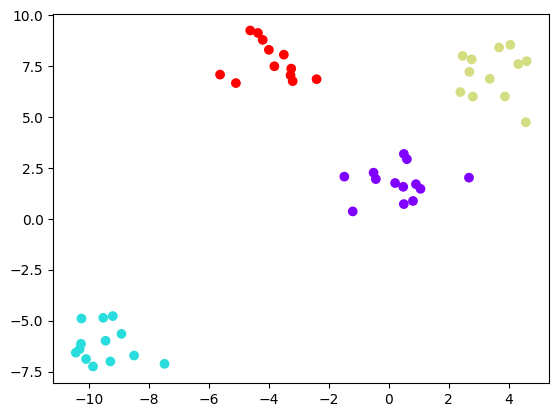

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

data = make_blobs(n_samples=50, n_features=2, centers=4, cluster_std=0.9, random_state=101)

plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='rainbow')
plt.show()

Jak widzisz, dane tworzą kilka skupisk, które zostały zaznaczone różnymi kolorami. Przyjrzyjmy się zmiennej `data` aby zrozumieć lepiej co kryje się w naszych danych

In [2]:
data

(array([[ -3.21196677,   6.77148776],
        [  2.76343805,   7.84142537],
        [ -0.51194094,   2.2729026 ],
        [ -9.87790909,  -7.24822961],
        [ -3.26098822,   7.38785043],
        [  0.20661591,   1.7648268 ],
        [ -4.00695687,   8.30948946],
        [  3.8739517 ,   6.01837662],
        [ -5.6360202 ,   7.09206506],
        [  2.68510419,   7.22736737],
        [-10.27958123,  -6.13329039],
        [ -3.82336166,   7.50231173],
        [ -8.50712973,  -6.71050499],
        [  2.38477702,   6.23325143],
        [  3.36667283,   6.88523996],
        [ -4.37239883,   9.13886602],
        [ -7.49115367,  -7.11879985],
        [  0.49779833,   0.73036689],
        [ -8.927623  ,  -5.64723762],
        [ -9.29819138,  -7.00107011],
        [ -1.48837887,   2.07946159],
        [  0.47818673,   1.57940341],
        [  2.67334311,   2.02850973],
        [  0.8039047 ,   0.88325126],
        [  0.49968744,   3.19423333],
        [-10.11030828,  -6.88134353],
        [  3

Kiedy przyjrzymy się im bliżej, zobaczymy że dane to `tuple`, którego pierwszym (zerowym) elementem jest dwuwymiarowa tablica `ndarray` ze współrzędnymi punktów (x, y) a drugim (pierwszym) elementem jest jednowymiarowy wektor oznaczający numery klastrów do jakich należą poszczególne punkty. Tutaj z góry znamy podział na klastry, w rzeczywistości jednak nie będziemy mieć takiej wiedzy.

Poniżej wydzielone zostały poszczególne części struktury `data`. Punkty, które masz za zadanie pogrupować w klastry to `data_points`. Użyj `data_clusters` jako odniesienia dla swoich wyników. Pamiętaj, że numery id klastrów są arbitralne i mogą zostać zamienione, np. wszystkie 1 to 3 a wszystkie 3 to 1.

In [3]:
data_points = data[0]
data_clusters = data[1]

In [4]:
print(data_points)
print(data_clusters)

[[ -3.21196677   6.77148776]
 [  2.76343805   7.84142537]
 [ -0.51194094   2.2729026 ]
 [ -9.87790909  -7.24822961]
 [ -3.26098822   7.38785043]
 [  0.20661591   1.7648268 ]
 [ -4.00695687   8.30948946]
 [  3.8739517    6.01837662]
 [ -5.6360202    7.09206506]
 [  2.68510419   7.22736737]
 [-10.27958123  -6.13329039]
 [ -3.82336166   7.50231173]
 [ -8.50712973  -6.71050499]
 [  2.38477702   6.23325143]
 [  3.36667283   6.88523996]
 [ -4.37239883   9.13886602]
 [ -7.49115367  -7.11879985]
 [  0.49779833   0.73036689]
 [ -8.927623    -5.64723762]
 [ -9.29819138  -7.00107011]
 [ -1.48837887   2.07946159]
 [  0.47818673   1.57940341]
 [  2.67334311   2.02850973]
 [  0.8039047    0.88325126]
 [  0.49968744   3.19423333]
 [-10.11030828  -6.88134353]
 [  3.6774952    8.42387633]
 [-10.4534956   -6.56923704]
 [  4.05296691   8.55355393]
 [-10.32445262  -6.39244732]
 [ -9.53561146  -4.85798756]
 [  0.90288087   1.71003341]
 [  4.57085197   4.75084619]
 [ -4.21271657   8.79772544]
 [  1.05490788

### Pomocnicze pojęcie - centroid

Zanim przejdziemy do omówienia algorytmu musimy zrozumieć czym jest centroid. Jest to pojęcie, które można dość intuicyjnie zrozumieć jako środek cieżkości zbioru punktów. Dla przestrzeni 2 wymiarowej i zbioru trzech punktów:

$$A = (x_1, y_1)$$

$$B = (x_2, y_2)$$

$$C = (x_3, y_3)$$

ich centroid to punkt wyznaczający geometryczny środek rozkładu:

$$centroid = ( (x_1 + x_2 + x_3)/3 , (y_1 + y_2 + y_3)/3 )$$

Innymi słowy jest to punkt, którego współrzędna x to średnia arytmetyczna współrzędnych x wszystkich punktów rozkładu i analogicznie dla współrzędnej y.

### Klasteryzacja

W metodzie K-means clustering aby przypisać numery klastrów poszczególnym punktom musimy wykonać następujący algorytm:

1. Określ z góry ile klastrów się spodziewasz otrzymać.
2. Przypisz każdemu punktowi losowy klaster (np. dla spodziewanych 4 klastrów ich numery id to 0, 1, 2, 3).
3. Wyznacz centroid każdego klastra (centroid zbioru wszystkich punktów należących do kolejnych klastrów).
4. Każdemu punktowi przypisz ponownie numer klastra. Tym razem nie będzie to losowe - każdy punkt powinien mieć taki numer klastra do którego centroidu ma najbliżej.
5. Powtarzaj punkty 3 oraz 4 tak długo aż w kolejnych iteracjach żaden punkt nie będzie zmieniał swojego klastra.

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Wygenerowanie danych
from sklearn.datasets import make_blobs

In [67]:
data = make_blobs(n_samples=50, n_features=2, centers=4, cluster_std=0.9, random_state=101)
data_points = data[0]

# Liczba klastrów
k = 4

# Inicjalizacja: losowe przypisanie klastrów do punktów
np.random.seed(42)  # Dla powtarzalności wyników
cluster_assignments = np.random.randint(0, k, size=len(data_points))

# print(data)
# print(data_points)

# print(len(data_points))
# print(data_points.shape[0])
# print(cluster_assignments)

In [68]:
def compute_centroids(data_points, cluster_assignments, k):
    """Oblicza centroidy dla każdego klastra."""
    centroids = np.array([data_points[cluster_assignments == i].mean(axis=0) for i in range(k)])
    return centroids

In [69]:
def assign_clusters(data_points, centroids):
    """Przypisuje punkty do najbliższego centroidu."""
    distances = np.linalg.norm(data_points[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

In [70]:
def kmeans(data_points, k, max_iters=100, tolerance=1e-4):
    """Wykonuje algorytm K-means."""
    # Inicjalizacja losowego przypisania klastrów
    cluster_assignments = np.random.randint(0, k, size=data_points.shape[0])
    
    for iteration in range(max_iters):
        # Oblicz centroidy na podstawie aktualnych przypisań klastrów
        centroids = compute_centroids(data_points, cluster_assignments, k)
        # print(centroids)
        # Przypisz punkty do najbliższego centroidu
        new_assignments = assign_clusters(data_points, centroids)
        # print(new_assignments)
        # Sprawdź, czy przypisania się zmieniły
        if np.all(cluster_assignments == new_assignments):
            print(f"K-means zakończono po {iteration+1} iteracjach.")
            break
        
        cluster_assignments = new_assignments
    
    return cluster_assignments, centroids

K-means zakończono po 4 iteracjach.
[2 1 0 3 2 0 2 1 2 1 3 2 3 1 1 2 3 0 3 3 0 0 0 0 0 3 1 3 1 3 3 0 1 2 0 1 2
 1 2 2 2 0 1 3 0 0 1 3 3 2]
[[ 0.31342885  1.76835166]
 [ 3.46287705  7.10974588]
 [-3.95561146  7.74440116]
 [-9.51879971 -6.17003389]]


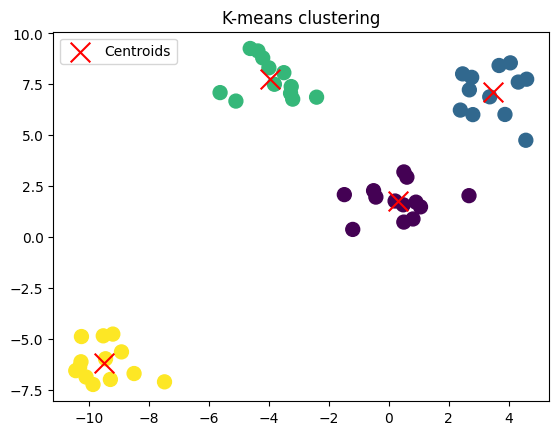

In [64]:
# Uruchomienie algorytmu K-means
final_assignments, final_centroids = kmeans(data_points, k)
print(final_assignments)
print(final_centroids)
# Wizualizacja wyników
plt.scatter(data_points[:, 0], data_points[:, 1], c=final_assignments, cmap='viridis', s=100)
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('K-means clustering')
plt.legend()
plt.show()


In [61]:
# ...

In [62]:
# ...

Wynik klastrowania niech będzie wektorem, który dla każdego punktu z tablicy `data_poins` będzie przechowywał informacje o numerze klastra. Nazwijmy ten wektor `new_clusters`.

In [63]:
new_clusters = ...

## Sprawdzenie rozwiązania

Utwórzmy zmienną `data2` na podstawie zmiennych `data_points` i `new_clusters`

In [14]:
data2 = (data_points, new_clusters)

Sprawdźmy jak wygląda to na wykresie

TypeError: float() argument must be a string or a real number, not 'ellipsis'

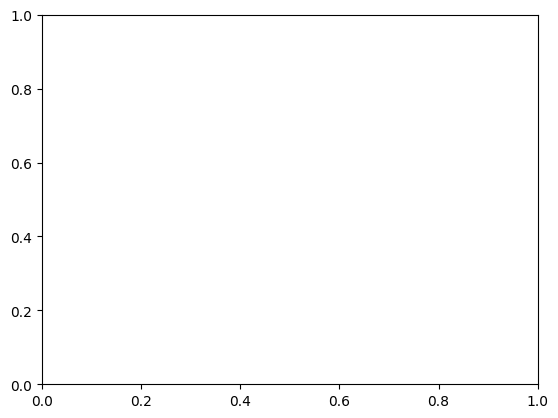

In [15]:
plt.scatter(data2[0][:,0],data2[0][:,1], c=data2[1], cmap='rainbow')
plt.show()